In [1]:
# %pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from scipy.stats import jarque_bera, chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report, precision_recall_fscore_support, roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve


In [2]:
data = pd.read_csv('cr_loan2.xls')

data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
data.shape

(32581, 12)

In [5]:
data.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

In [4]:
data.dtypes.value_counts()

int64      5
object     4
float64    3
dtype: int64

In [6]:
data.drop_duplicates(inplace=True)

data.shape

(32416, 12)

In [7]:
# Univariate analysis

data.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [8]:
# Dealing with missing data

data = data.drop(data[data['loan_int_rate'].isna()].index)

data['person_emp_length'].fillna((data['person_emp_length'].median()), inplace=True)

data.shape

(29321, 12)

In [10]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,29321.000000,2.932100e+04,29321.000000,29321.000000,29321.000000,29321.000000,29321.000000,29321.00000
mean,27.726544,6.602976e+04,4.768050,9587.635142,11.017265,0.219911,0.170141,5.79513
std,6.306105,6.192304e+04,4.100983,6316.319639,3.241680,0.414193,0.106900,4.03579
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.00000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.00000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.00000
75%,30.000000,7.910000e+04,7.000000,12250.000000,13.470000,0.000000,0.230000,8.00000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.00000


In [10]:
data.describe(include='object')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,29321,29321,29321,29321
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,14838,5820,9713,24122


In [11]:
object_columns = data.select_dtypes(include=['object'])

for col in object_columns:
    print(data[col].value_counts())
    print("=================================")

RENT        14838
MORTGAGE    12054
OWN          2336
OTHER          93
Name: person_home_ownership, dtype: int64
EDUCATION            5820
MEDICAL              5426
VENTURE              5119
PERSONAL             4994
DEBTCONSOLIDATION    4683
HOMEIMPROVEMENT      3279
Name: loan_intent, dtype: int64
A    9713
B    9337
C    5809
D    3309
E     880
F     214
G      59
Name: loan_grade, dtype: int64
N    24122
Y     5199
Name: cb_person_default_on_file, dtype: int64


0    0.780089
1    0.219911
Name: loan_status, dtype: float64

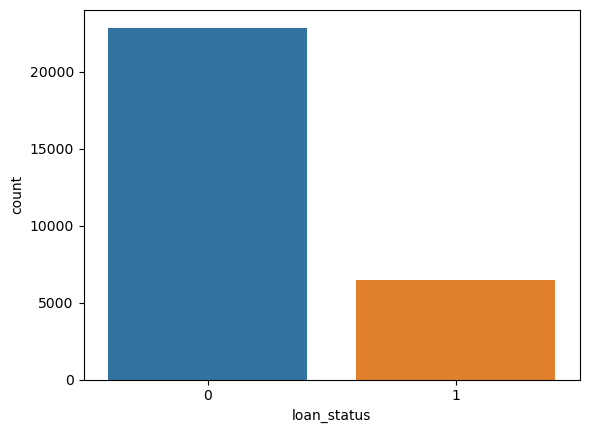

In [12]:
sns.countplot(x=data['loan_status'])

data['loan_status'].value_counts() / data.shape[0]

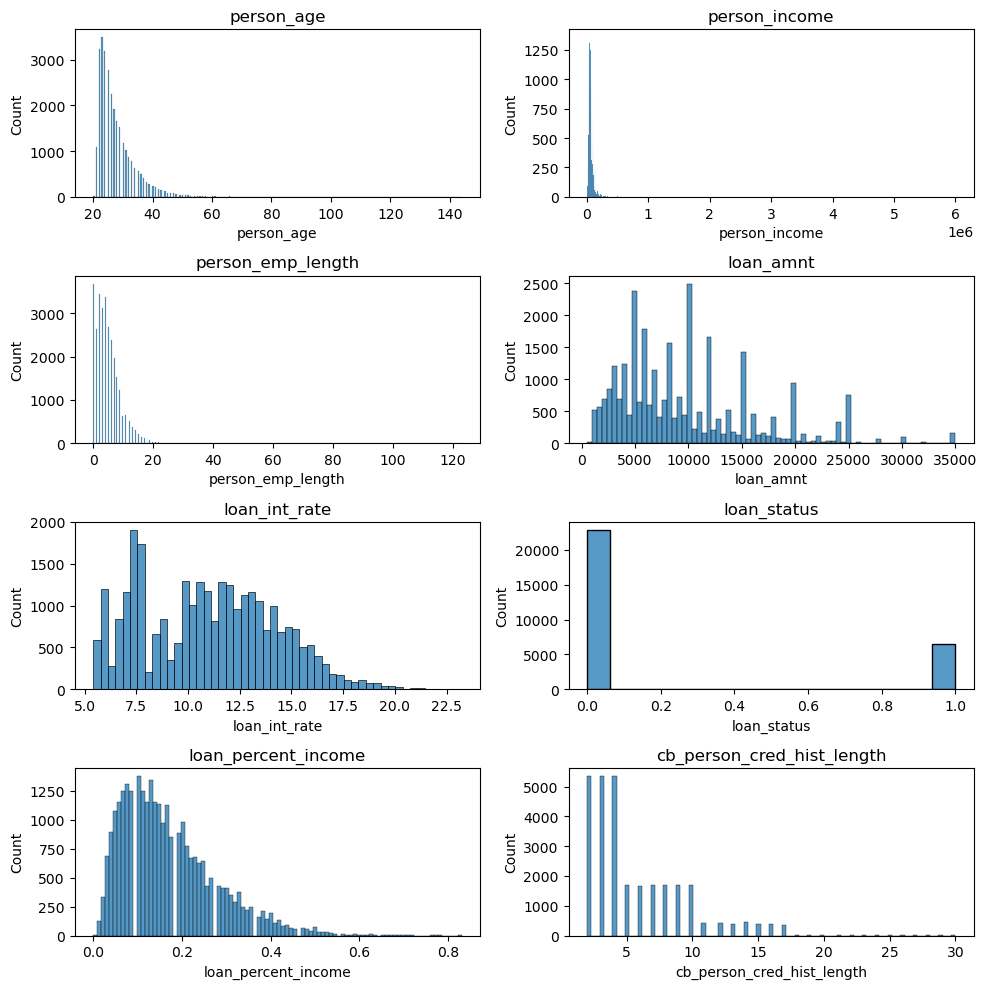

In [14]:
num_columns = data.select_dtypes(exclude=['object'])
columns = num_columns.columns
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
sns.histplot(num_columns.iloc[:,0],ax=axs[0, 0]).set_title(columns[0])
sns.histplot(num_columns.iloc[:,1],ax=axs[0, 1]).set_title(columns[1])
sns.histplot(num_columns.iloc[:,2],ax=axs[1, 0]).set_title(columns[2])
sns.histplot(num_columns.iloc[:,3],ax=axs[1, 1]).set_title(columns[3])
sns.histplot(num_columns.iloc[:,4],ax=axs[2, 0]).set_title(columns[4])
sns.histplot(num_columns.iloc[:,5],ax=axs[2, 1]).set_title(columns[5])
sns.histplot(num_columns.iloc[:,6],ax=axs[3, 0]).set_title(columns[6])
sns.histplot(num_columns.iloc[:,7],ax=axs[3, 1]).set_title(columns[7])
fig.tight_layout()

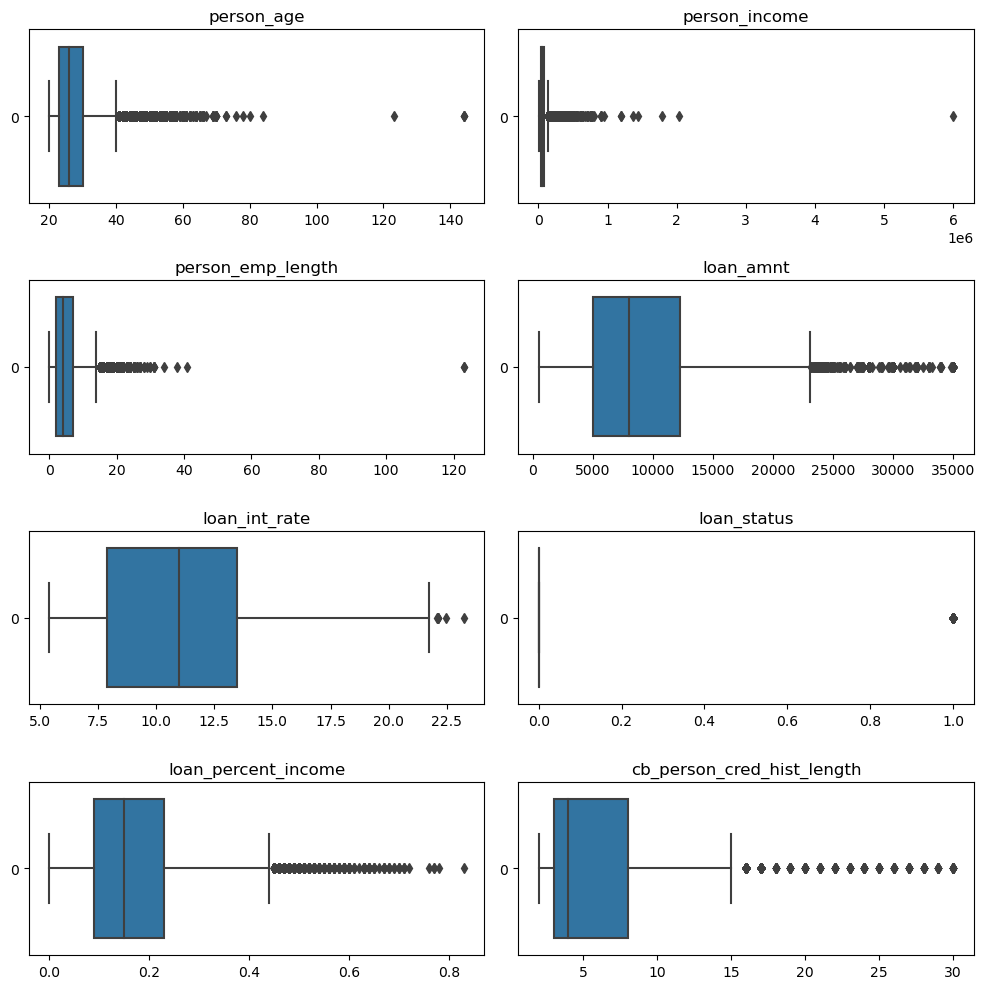

In [15]:
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
sns.boxplot(num_columns.iloc[:,0],ax=axs[0, 0],orient='h').set_title(columns[0])
sns.boxplot(num_columns.iloc[:,1],ax=axs[0, 1],orient='h').set_title(columns[1])
sns.boxplot(num_columns.iloc[:,2],ax=axs[1, 0],orient='h').set_title(columns[2])
sns.boxplot(num_columns.iloc[:,3],ax=axs[1, 1],orient='h').set_title(columns[3])
sns.boxplot(num_columns.iloc[:,4],ax=axs[2, 0],orient='h').set_title(columns[4])
sns.boxplot(num_columns.iloc[:,5],ax=axs[2, 1],orient='h').set_title(columns[5])
sns.boxplot(num_columns.iloc[:,6],ax=axs[3, 0],orient='h').set_title(columns[6])
sns.boxplot(num_columns.iloc[:,7],ax=axs[3, 1],orient='h').set_title(columns[7])
fig.tight_layout()

In [16]:
# Removing anomalies 

data = data.drop(data[data['person_emp_length'] > 60].index)

data = data.drop(data[data['person_age'] > 100].index)

data.shape

(29315, 12)

0    0.780078
1    0.219922
Name: loan_status, dtype: float64

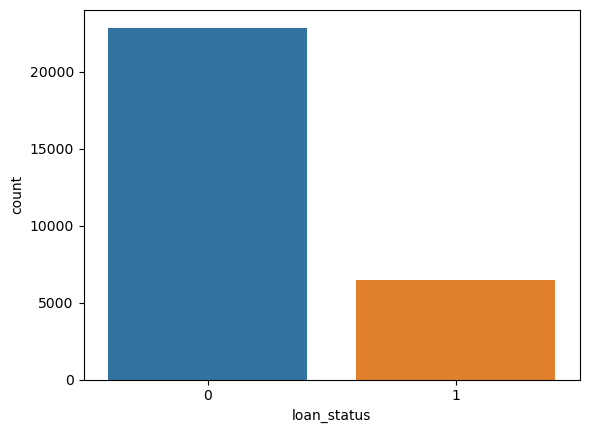

In [34]:
sns.countplot(x=data['loan_status'])

data['loan_status'].value_counts() / data.shape[0]

In [17]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,29315.000000,2.931500e+04,29315.000000,29315.000000,29315.000000,29315.000000,29315.000000,29315.000000
mean,27.711820,6.581196e+04,4.759884,9586.486440,11.017099,0.219922,0.170142,5.794951
std,6.170817,5.129993e+04,3.983167,6314.459818,3.241718,0.414200,0.106870,4.034470
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.905000e+04,7.000000,12250.000000,13.470000,0.000000,0.230000,8.000000
max,84.000000,2.039784e+06,41.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [24]:
def kde_loan_status(var_name, df, ax):
    
    corr = df['loan_status'].corr(df[var_name])
    med_repaid = df.loc[df['loan_status'] == 0, var_name].median()
    med_not_repaid = df.loc[df['loan_status'] == 1, var_name].median()
    skew_repaid = df.loc[df['loan_status'] == 0, var_name].skew()
    skew_not_repaid = df.loc[df['loan_status'] == 1, var_name].skew()
    kurt_repaid = df.loc[df['loan_status'] == 0, var_name].kurt()
    kurt_not_repaid = df.loc[df['loan_status'] == 1, var_name].kurt()
    test_statistic_repaid, p_value_repaid = jarque_bera(df.loc[df['loan_status'] == 0, var_name])
    test_statistic_not_repaid, p_value_not_repaid = jarque_bera(df.loc[df['loan_status'] == 1, var_name])
    
    plt.figure(figsize=(12, 6))

    sns.kdeplot(df.loc[df['loan_status'] == 0, var_name], label='loan_status == 0', ax=ax)
    sns.kdeplot(df.loc[df['loan_status'] == 1, var_name], label='loan_status == 1', ax=ax)
    
    ax.set_xlabel(var_name)
    ax.set_ylabel('Density')
    ax.set_title('%s density' % var_name)
    ax.legend()

    BOLD = '\033[1m'
    RESET = '\033[0m'

    print(f"{BOLD}{var_name}{RESET}")
    print('Correlation between %s and the target variable is %0.4f' % (var_name, corr))
    print('Median for loans that were not repaid = %0.4f' % med_not_repaid)
    print('Median for loans that were repaid = %0.4f' % med_repaid)
    print('Skewness for loans that were not repaid = %0.4f' % skew_not_repaid)
    print('Skewness for loans that were repaid = %0.4f' % skew_repaid)
    print('Kurtosis for loans that were not repaid = %0.4f' % kurt_not_repaid)
    print('Kurtosis for loans that were repaid = %0.4f' % kurt_repaid)
    print('Jarque-Bera test statistic for loans that were not repaid = %0.4f' % test_statistic_not_repaid)
    print('p-value for loans that were not repaid = %0.4f' % p_value_not_repaid)
    print('Jarque-Bera test statistic for loans that were repaid = %0.4f' % test_statistic_repaid)
    print('p-value for loans that were repaid = %0.4f' % p_value_repaid)
    
    if p_value_not_repaid < 0.05:
        print(f"Distribution of {var_name} for loans that were not repaid does not follow a normal distribution")
    else:
        print(f"Distribution of {var_name} for loans that were not repaid follows a normal distribution")

    if p_value_repaid < 0.05:
        print(f"Distribution of {var_name} for loans that were repaid does not follow a normal distribution")
    else:
        print(f"Distribution of {var_name} for loans that were repaid follows a normal distribution")

    print('------------------------------------------------------------------------------------')

person_age
Correlation between person_age and the target variable is -0.0218
Median for loans that were not repaid = 26.0000
Median for loans that were repaid = 26.0000
Skewness for loans that were not repaid = 1.9916
Skewness for loans that were repaid = 1.8958
Kurtosis for loans that were not repaid = 5.6487
Kurtosis for loans that were repaid = 5.5402
Jarque-Bera test statistic for loans that were not repaid = 12815.2561
p-value for loans that were not repaid = 0.0000
Jarque-Bera test statistic for loans that were repaid = 42927.0087
p-value for loans that were repaid = 0.0000
Distribution of person_age for loans that were not repaid does not follow a normal distribution
Distribution of person_age for loans that were repaid does not follow a normal distribution
------------------------------------------------------------------------------------
person_income
Correlation between person_income and the target variable is -0.1722
Median for loans that were not repaid = 42000.0000
Median

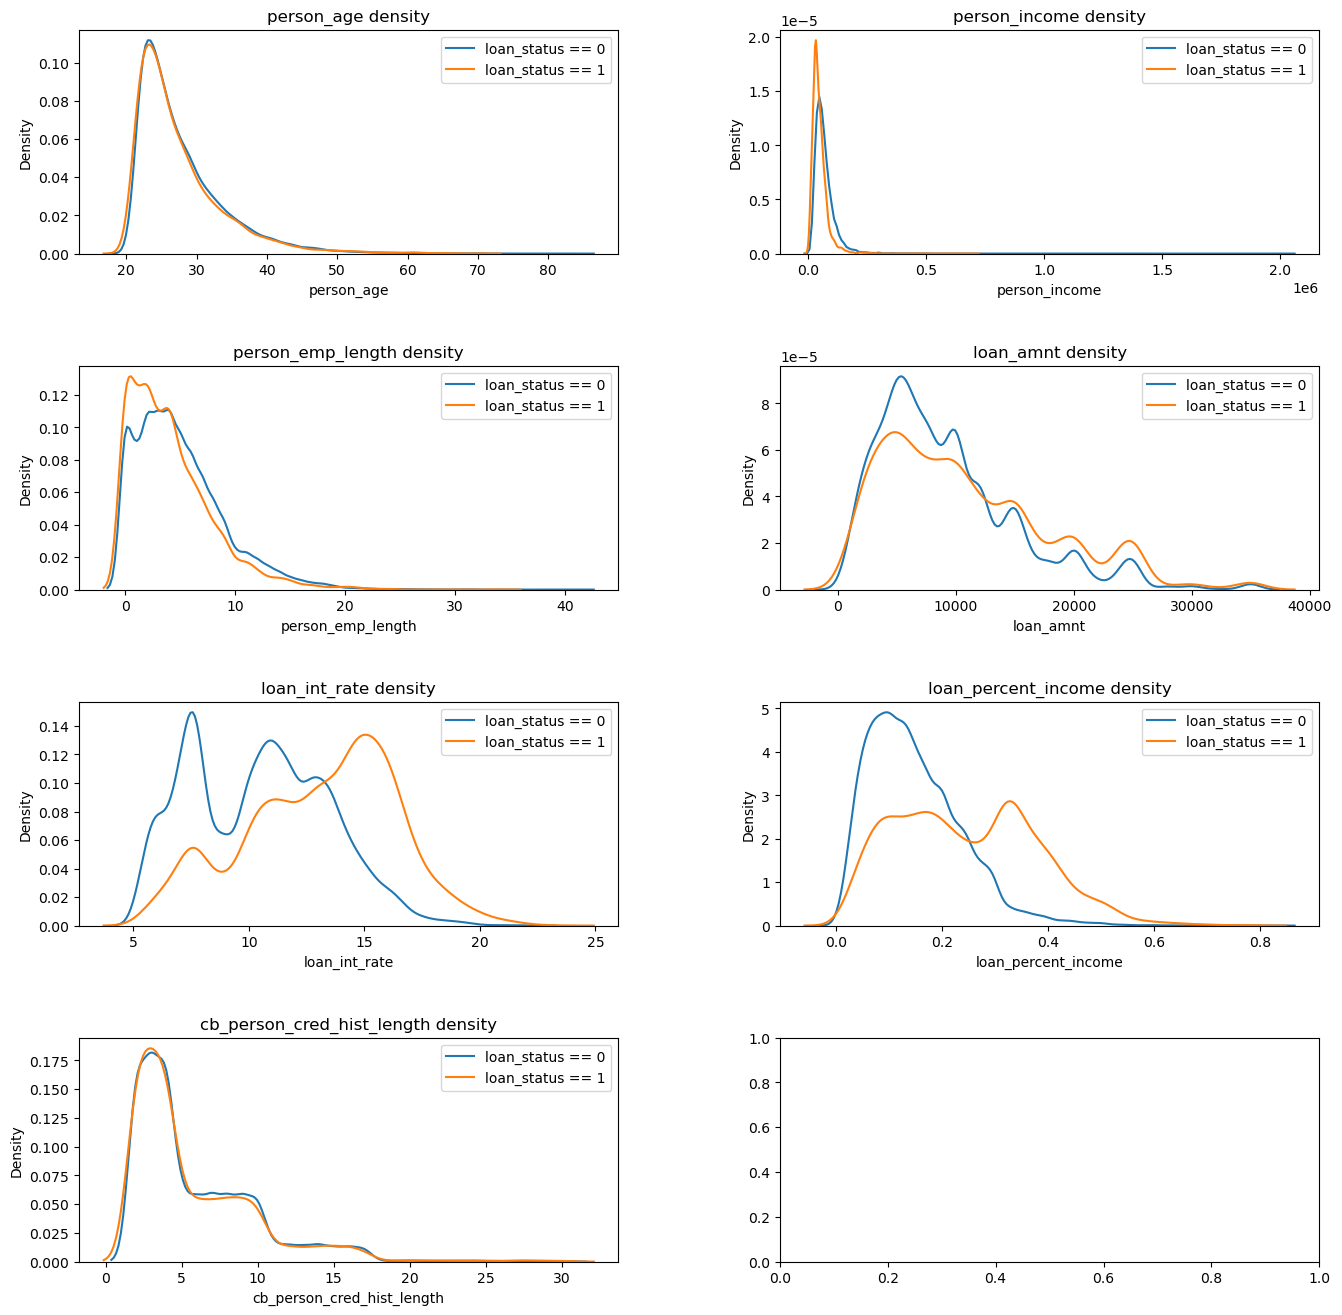

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [25]:
fig, axs = plt.subplots(4, 2, figsize=(16, 16))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
variables_to_plot = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']  

for i, var in enumerate(variables_to_plot):
    row = i // 2
    col = i % 2
    kde_loan_status(var, data, ax=axs[row, col])

plt.tight_layout()
plt.show()


In [28]:
data.describe(include='object')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,29315,29315,29315,29315
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,14835,5818,9712,24117


In [29]:
def cat_variables_loan_status(var_name, hue, df, ax):
    sns.countplot(x=var_name, hue=hue, data=df, ax=ax)
    ax.set_xlabel(var_name)
    ax.set_ylabel('Count')
    ax.set_title('%s distribution' % var_name)
    ax.tick_params(axis='x', labelsize=7)

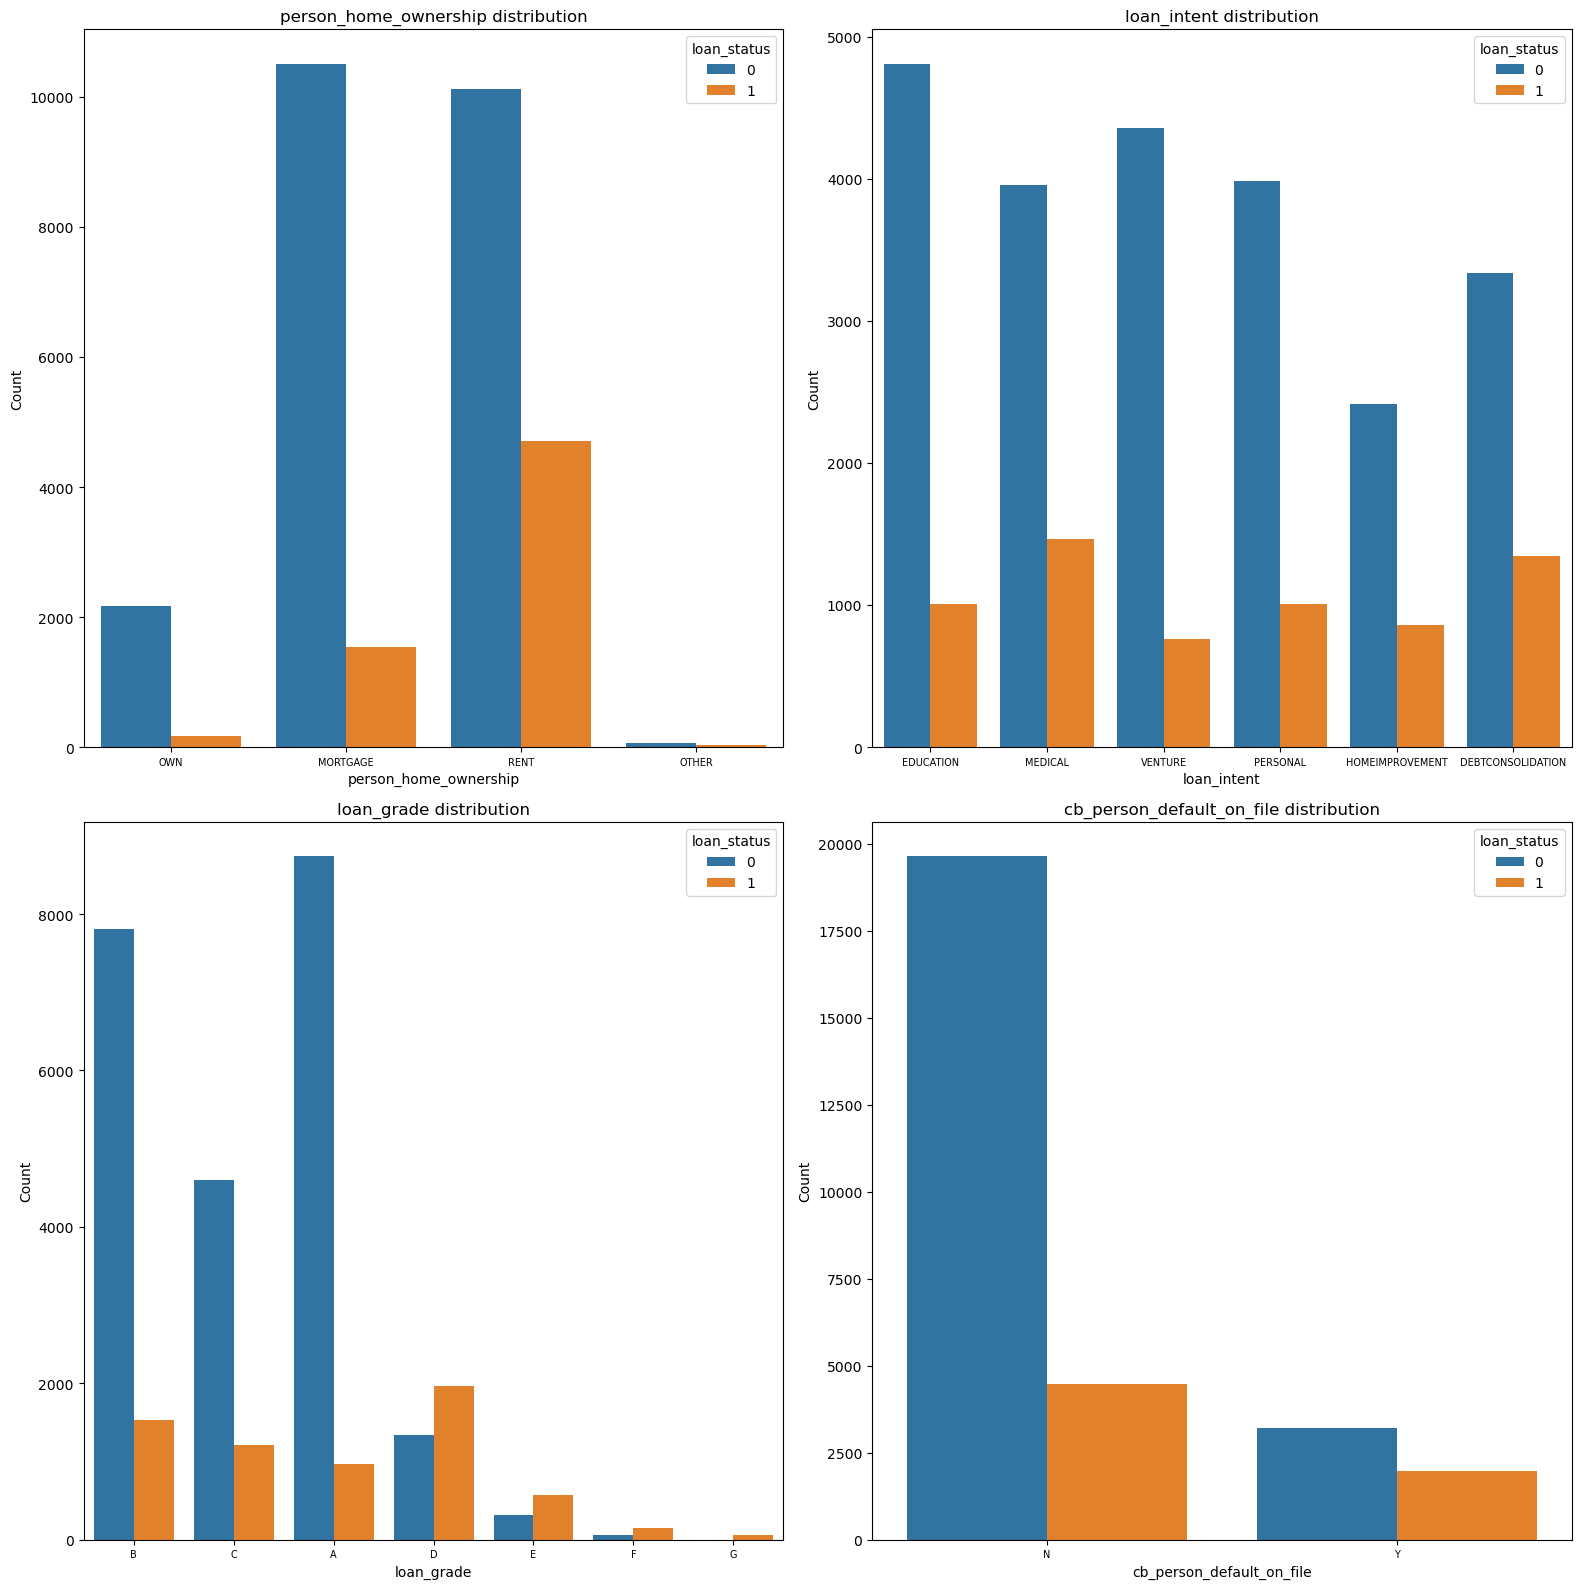

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

categorical_variables_to_plot = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']  

for i, var in enumerate(categorical_variables_to_plot):
    row = i // 2
    col = i % 2
    cat_variables_loan_status(var, 'loan_status', data, ax=axs[row, col])

plt.tight_layout()
plt.show()

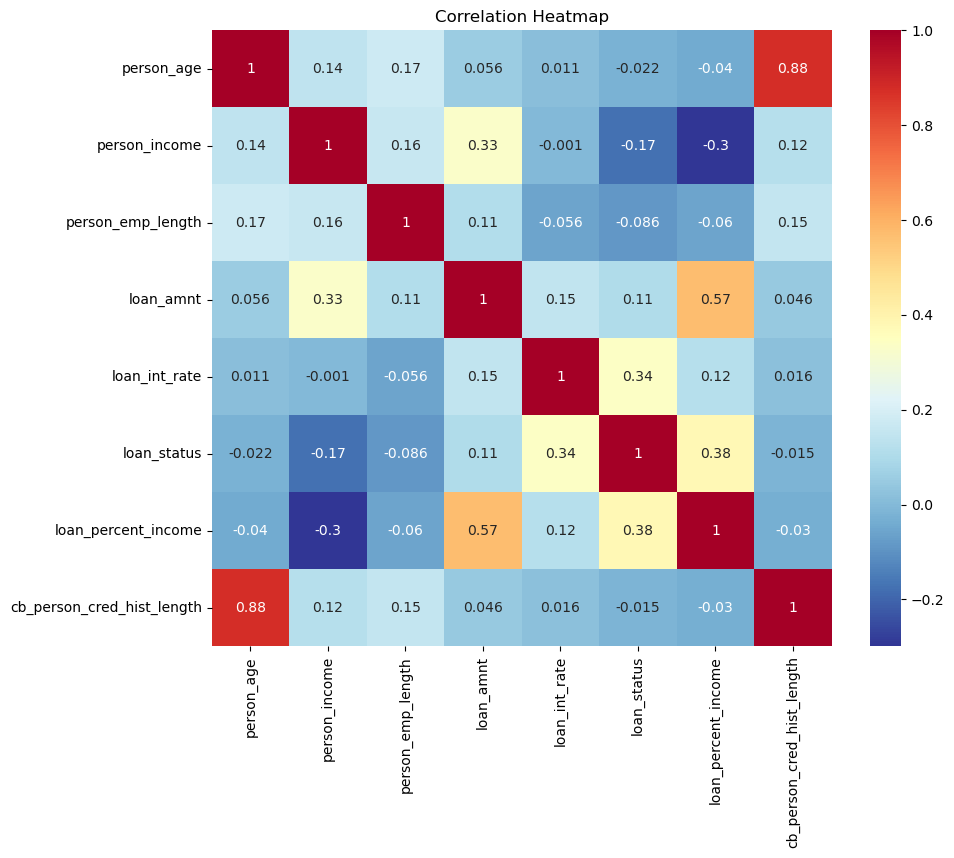

In [31]:
# Bivariate analysis - numerical variables

plt.figure(figsize=(10,8))
corr = num_columns.corr()
sns.heatmap(corr, cmap = plt.cm.RdYlBu_r, annot = True)
plt.title('Correlation Heatmap');

In [32]:
data.drop('cb_person_cred_hist_length', axis=1, inplace=True)

/var/folders/cb/rfcndmvn0v94zv5yyvyjkn780000gn/T/ipykernel_1341/3618712675.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  object_columns_with_target['loan_status'] = object_columns_with_target['loan_status'].map({0:'No',1:'Yes'}).astype('category')


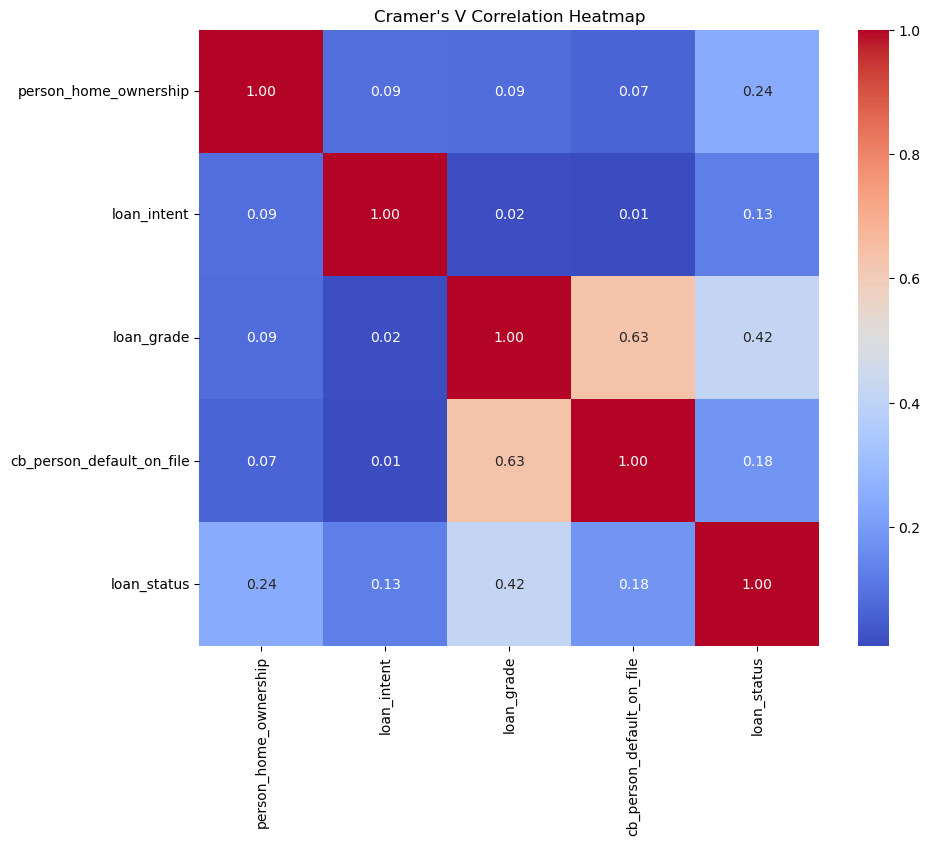

In [33]:
# Bivariate analysis - categorical variables 

object_columns_with_target = data[['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file', 'loan_status']]
object_columns_with_target['loan_status'] = object_columns_with_target['loan_status'].map({0:'No',1:'Yes'}).astype('category')

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramer_v_matrix = pd.DataFrame(index=object_columns_with_target.columns, columns=object_columns_with_target.columns)
for i, col1 in enumerate(object_columns_with_target.columns):
    for j, col2 in enumerate(object_columns_with_target.columns):
            confusion_matrix = pd.crosstab(object_columns_with_target[col1], object_columns_with_target[col2])
            cramer_v_matrix.loc[col1, col2] = cramers_v(confusion_matrix)
            
plt.figure(figsize=(10, 8))
sns.heatmap(cramer_v_matrix.astype(float), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Cramer's V Correlation Heatmap")
plt.show()

In [35]:
# One-hot encoding of categorical variables

data.reset_index(drop=True, inplace=True)

num = data.select_dtypes(exclude=['object'])
obj = data.select_dtypes(include=['object'])

columns_onehot = pd.get_dummies(obj)
dataset = pd.concat([num, columns_onehot], axis=1)

In [36]:
# Split into training and test sets

X = dataset.drop('loan_status', axis=1)
y = dataset['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)


In [40]:
# Logistic regression model selection using undersampled training set

X_y_train = pd.concat([X_train.reset_index(drop = True),
                       y_train.reset_index(drop = True)], axis = 1)
count_nondefault, count_default = X_y_train['loan_status'].value_counts()

nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]

nondefaults_under = nondefaults.sample(count_default, random_state=42)

X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

X_train_under = X_y_train_under.drop('loan_status', axis=1)
y_train_under = X_y_train_under['loan_status']

# Logistic regression models with L1 and L2 penalty: comparison

np.random.seed(42)

grid = {'penalty': ['l1', 'l2'],
          'C': np.linspace(0.001, 0.2, 100)
         }

f1_scorer = make_scorer(f1_score)

tuning_lr = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000, solver='liblinear'),
                             param_grid=grid,
                             scoring=f1_scorer,
                             n_jobs=1,
                             cv=3,
                             verbose=0)
tuning_lr.fit(X_train_under, y_train_under)

print("Best parameters:", tuning_lr.best_params_)
print("Best score:", "{:.2f}".format(tuning_lr.best_score_))

best_lr_model_under = tuning_lr.best_estimator_

predictions_train_under = best_lr_model_under.predict(X_train_under)
accuracy_train_under = accuracy_score(y_train_under, predictions_train_under)
train_f1 = f1_score(y_train_under, predictions_train_under)

predictions_test = best_lr_model_under.predict(X_test) 
accuracy_test = accuracy_score(y_test, predictions_test)
test_f1 = f1_score(y_test, predictions_test)

print("Accuracy on undersampled training set for the best model: %.2f" % accuracy_train_under)
print("F1-score on undersampled training set for the best model: %.2f" % train_f1)
print("Accuracy on test set for the best model: %.2f" % accuracy_test)
print("F1-score on test set for the best model: %.2f" % test_f1)
print("------------------------------------------------------------------")


# Logistic regression models with elasticnet penalty

np.random.seed(42)

grid_elasticnet = {'l1_ratio': np.linspace(0, 1, 100)}

tuning_lr_elasticnet = GridSearchCV(LogisticRegression(penalty='elasticnet', random_state=42, max_iter=10000, solver='saga'),
                             param_grid=grid_elasticnet,
                             scoring=f1_scorer,
                             n_jobs=1,
                             cv=3,
                             verbose=0)
tuning_lr_elasticnet.fit(X_train_under, y_train_under)

print("Best parameters:", tuning_lr_elasticnet.best_params_)
print("Best score:", "{:.2f}".format(tuning_lr_elasticnet.best_score_))

best_lr_model_under_elasticnet = tuning_lr_elasticnet.best_estimator_

predictions_train_under_elasticnet = best_lr_model_under_elasticnet.predict(X_train_under)
accuracy_train_under_elasticnet = accuracy_score(y_train_under, predictions_train_under_elasticnet)
train_f1_elasticnet = f1_score(y_train_under, predictions_train_under_elasticnet)

predictions_test_elasticnet = best_lr_model_under_elasticnet.predict(X_test) 
accuracy_test_elasticnet = accuracy_score(y_test, predictions_test_elasticnet)
test_f1_elasticnet = f1_score(y_test, predictions_test_elasticnet)

print("Accuracy on undersampled training set for the best model with elasticnet penalty: %.2f" % accuracy_train_under_elasticnet)
print("F1-score on undersampled training set for the best model with elasticnet penalty: %.2f" % train_f1_elasticnet)
print("Accuracy on test set for the best model with elasticnet penalty: %.2f" % accuracy_test_elasticnet)
print("F1-score on test set for the best model with elasticnet penalty %.2f" % test_f1_elasticnet)



Best parameters: {'C': 0.05728282828282828, 'penalty': 'l1'}
Best score: 0.80
Accuracy on undersampled training set for the best model: 0.80
F1-score on undersampled training set for the best model: 0.80
Accuracy on test set for the best model: 0.81
F1-score on test set for the best model: 0.63
------------------------------------------------------------------
Best parameters: {'l1_ratio': 0.0}
Best score: 0.65
Accuracy on undersampled training set for the best model with elasticnet penalty: 0.67
F1-score on undersampled training set for the best model with elasticnet penalty: 0.65
Accuracy on test set for the best model with elasticnet penalty: 0.68
F1-score on test set for the best model with elasticnet penalty 0.45


In [41]:
# Logistic regression model selection using the entire training set

# Logistic regression models with L1 and L2 penalty: comparison

np.random.seed(42)

tuning_lr.fit(X_train, y_train)

print("Best parameters:", tuning_lr.best_params_)
print("Best score:", "{:.2f}".format(tuning_lr.best_score_))

best_lr_model = tuning_lr.best_estimator_

predictions_train_entire = best_lr_model.predict(X_train)
accuracy_train_entire = accuracy_score(y_train, predictions_train_entire)
train_f1_entire = f1_score(y_train, predictions_train_entire)

predictions_test_entire = best_lr_model.predict(X_test) 
accuracy_test_entire = accuracy_score(y_test, predictions_test_entire)
test_f1_entire = f1_score(y_test, predictions_test_entire)

print("Accuracy on training set for the best model: %.2f" % accuracy_train_entire)
print("F1-score on training set for the best model: %.2f" % train_f1_entire)
print("Accuracy on test set for the best model: %.2f" % accuracy_test_entire)
print("F1-score on test set for the best model: %.2f" % test_f1_entire)
print("------------------------------------------------------------------")

# Logistic regression models with elasticnet penalty

np.random.seed(42)

tuning_lr_elasticnet.fit(X_train, y_train)

print("Best parameters:", tuning_lr_elasticnet.best_params_)
print("Best score:", "{:.2f}".format(tuning_lr_elasticnet.best_score_))

best_lr_model_elasticnet = tuning_lr_elasticnet.best_estimator_

predictions_train_entire_elasticnet = best_lr_model_elasticnet.predict(X_train)
accuracy_train_entire_elasticnet = accuracy_score(y_train, predictions_train_entire_elasticnet)
train_f1_entire_elasticnet = f1_score(y_train, predictions_train_entire_elasticnet)

predictions_test_entire_elasticnet = best_lr_model_elasticnet.predict(X_test) 
accuracy_test_entire_elasticnet = accuracy_score(y_test, predictions_test_entire_elasticnet)
test_f1_entire_elasticnet = f1_score(y_test, predictions_test_elasticnet)

print("Accuracy on training set for the best model with elasticnet penalty: %.2f" % accuracy_train_entire_elasticnet)
print("F1-score on training set for the best model with elasticnet penalty: %.2f" % train_f1_entire_elasticnet)
print("Accuracy on test set for the best model with elasticnet penalty: %.2f" % accuracy_test_entire_elasticnet)
print("F1-score on test set for the best model with elasticnet penalty: %.2f" % test_f1_entire_elasticnet)

Best parameters: {'C': 0.16582828282828282, 'penalty': 'l1'}
Best score: 0.64
Accuracy on training set for the best model: 0.87
F1-score on training set for the best model: 0.65
Accuracy on test set for the best model: 0.87
F1-score on test set for the best model: 0.66
------------------------------------------------------------------
Best parameters: {'l1_ratio': 0.0}
Best score: 0.28
Accuracy on training set for the best model with elasticnet penalty: 0.80
F1-score on training set for the best model with elasticnet penalty: 0.28
Accuracy on test set for the best model with elasticnet penalty: 0.81
F1-score on test set for the best model with elasticnet penalty: 0.45


In [42]:
# XGBoost Classifier using undersampled training set

np.random.seed(42)

grid_xgb = {'max_depth': range(3,10,2),
          'min_child_weight': range(1,6,2)
          }

tuning_xgb = GridSearchCV(xgb.XGBClassifier(seed=42),
                             param_grid=grid_xgb,
                             scoring=f1_scorer,
                             n_jobs=1,
                             cv=3,
                             verbose=0)
tuning_xgb.fit(X_train_under, y_train_under)

print("Best parameters:", tuning_xgb.best_params_)
print("Best score:", "{:.2f}".format(tuning_xgb.best_score_))

best_xgb_model_under = tuning_xgb.best_estimator_

predictions_train_under_xgb = best_xgb_model_under.predict(X_train_under)
accuracy_train_under_xgb = accuracy_score(y_train_under, predictions_train_under_xgb)
train_f1_under_xgb = f1_score(y_train_under, predictions_train_under_xgb)

predictions_test_under_xgb = best_xgb_model_under.predict(X_test) 
accuracy_test_under_xgb = accuracy_score(y_test, predictions_test_under_xgb)
test_f1_under_xgb = f1_score(y_test, predictions_test_under_xgb)

print("Accuracy on undersampled training set for the best XGBoost model: %.2f" % accuracy_train_under_xgb)
print("F1-score on undersampled training set for the best XGBoost model: %.2f" % train_f1_under_xgb)
print("Accuracy on test set for the best XGBoost model: %.2f" % accuracy_test_under_xgb)
print("F1-score on test set for the best XGBoost model %.2f" % test_f1_under_xgb)

Best parameters: {'max_depth': 5, 'min_child_weight': 1}
Best score: 0.86
Accuracy on undersampled training set for the best XGBoost model: 0.93
F1-score on undersampled training set for the best XGBoost model: 0.93
Accuracy on test set for the best XGBoost model: 0.90
F1-score on test set for the best XGBoost model 0.78


In [43]:
# XGBoost Classifier using the entire training set

np.random.seed(42)

tuning_xgb.fit(X_train, y_train)

print("Best parameters:", tuning_xgb.best_params_)
print("Best score:", "{:.2f}".format(tuning_xgb.best_score_))

best_xgb_model = tuning_xgb.best_estimator_

predictions_train_xgb = best_xgb_model.predict(X_train)
accuracy_train_xgb = accuracy_score(y_train, predictions_train_xgb)
train_f1_xgb = f1_score(y_train, predictions_train_xgb)

predictions_test_xgb = best_xgb_model.predict(X_test) 
accuracy_test_xgb = accuracy_score(y_test, predictions_test_xgb)
test_f1_xgb = f1_score(y_test, predictions_test_xgb)

print("Accuracy on the entire training set for the best XGBoost model: %.2f" % accuracy_train_xgb)
print("F1-score on the entire training set for the best XGBoost model: %.2f" % train_f1_xgb)
print("Accuracy on test set for the best XGBoost model: %.2f" % accuracy_test_xgb)
print("F1-score on test set for the best XGBoost model: %.2f" % test_f1_xgb)

Best parameters: {'max_depth': 7, 'min_child_weight': 1}
Best score: 0.83
Accuracy on the entire training set for the best XGBoost model: 0.97
F1-score on the entire training set for the best XGBoost model: 0.92
Accuracy on test set for the best XGBoost model: 0.93
F1-score on test set for the best XGBoost model: 0.83


0    4047
1    1816
Name: loan_status, dtype: int64
              precision    recall  f1-score   support

 Non-Default       0.92      0.82      0.87      4570
     Default       0.54      0.76      0.63      1293

    accuracy                           0.81      5863
   macro avg       0.73      0.79      0.75      5863
weighted avg       0.84      0.81      0.82      5863

---------------------------------------------------------------------------------
0    4846
1    1017
Name: loan_status, dtype: int64
              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      4570
     Default       0.95      0.75      0.83      1293

    accuracy                           0.93      5863
   macro avg       0.94      0.87      0.90      5863
weighted avg       0.94      0.93      0.93      5863

---------------------------------------------------------------------------------


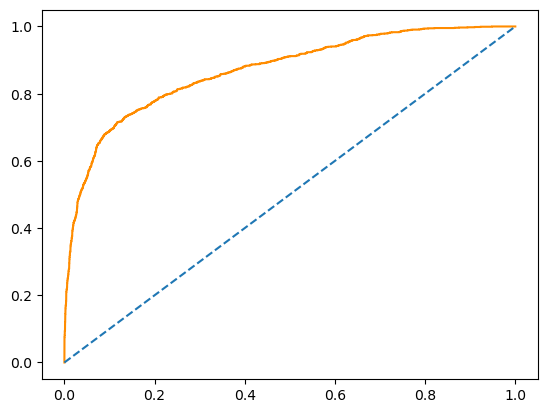

AUC for the best model: 0.87


/Users/wiktoriaceniuk/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wiktoriaceniuk/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wiktoriaceniuk/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

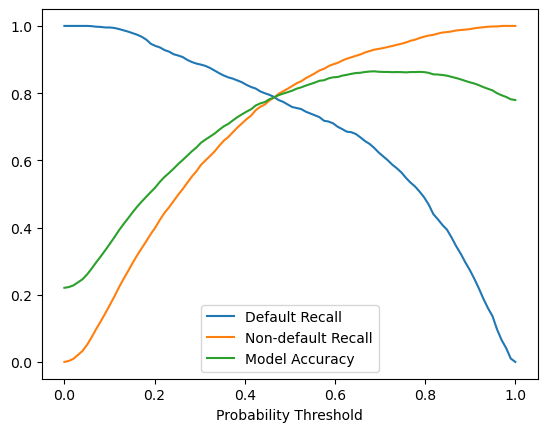

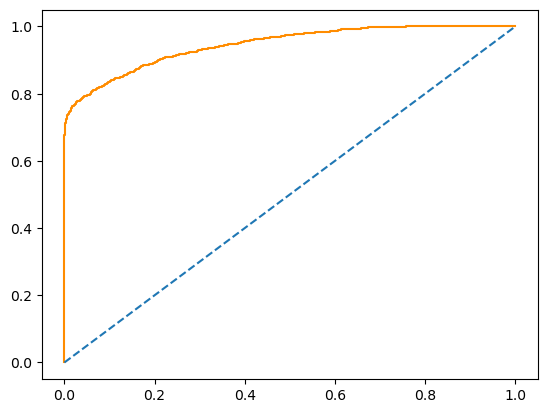

/Users/wiktoriaceniuk/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wiktoriaceniuk/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC for the best model: 0.95


/Users/wiktoriaceniuk/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wiktoriaceniuk/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


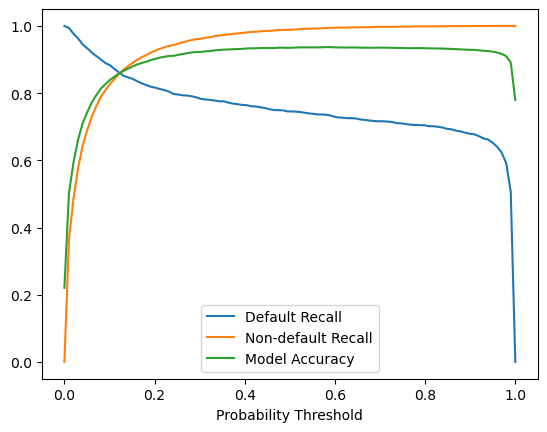

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

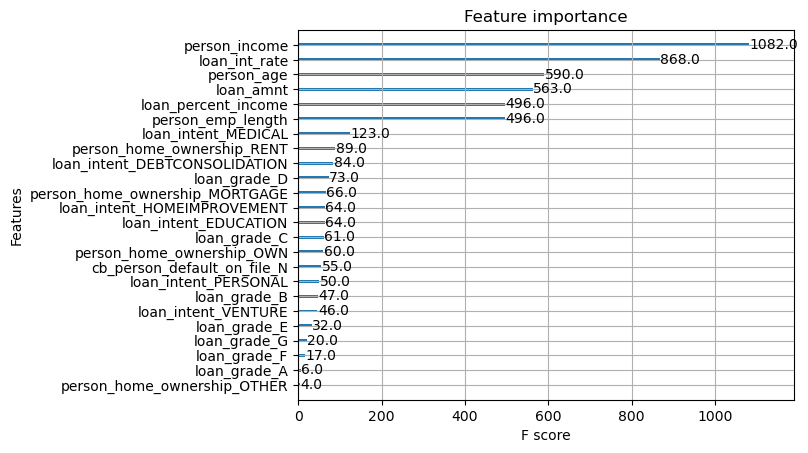

In [44]:
# Best models performance comparison

best_models_predictions = [predictions_test, predictions_test_xgb]

for prediction in best_models_predictions:
    prediction = pd.DataFrame(prediction, columns=['loan_status'])
    print(prediction['loan_status'].value_counts())
    target_names = ['Non-Default', 'Default']
    print(classification_report(y_test, prediction['loan_status'], target_names=target_names))
    print('---------------------------------------------------------------------------------')

best_models = [best_lr_model_under, best_xgb_model]

intersection_thresholds = []

for model in best_models:
    predictions_proba_test = model.predict_proba(X_test)
    prob_default = predictions_proba_test[:, 1]
    fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
    plt.plot(fallout, sensitivity, color = 'darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.show()
    auc = roc_auc_score(y_test, prob_default)
    print(f"AUC for the best model: {auc :.2f}")
    predictions_proba_test_df = pd.DataFrame(predictions_proba_test[:, 1], columns=['prob_default'])
    thresholds = np.linspace(0, 1, 100)
    default_recalls = []
    non_default_recalls = []
    accuracies = []
    for thresh in thresholds:
        predictions_proba_test_df['loan_status'] = predictions_proba_test_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
        default_recall = precision_recall_fscore_support(y_test, predictions_proba_test_df['loan_status'])[1][1]
        non_default_recall = precision_recall_fscore_support(y_test, predictions_proba_test_df['loan_status'])[1][0]
        accuracy = accuracy_score(y_test, predictions_proba_test_df['loan_status'])
        
        default_recalls.append(default_recall)
        non_default_recalls.append(non_default_recall)
        accuracies.append(accuracy)
        
    plt.plot(thresholds,default_recalls)
    plt.plot(thresholds,non_default_recalls)
    plt.plot(thresholds,accuracies)
    plt.xlabel("Probability Threshold")
    plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
    plt.show()

    min_difference = float('inf')

    for i in range(len(thresholds)):
        difference = abs(default_recalls[i] - non_default_recalls[i]) + abs(default_recalls[i] - accuracies[i]) + abs(non_default_recalls[i] - accuracies[i])
        if difference < min_difference:
            min_difference = difference
            intersection_threshold = thresholds[i]

    intersection_thresholds.append(intersection_threshold)

xgb.plot_importance(best_xgb_model, importance_type='weight')

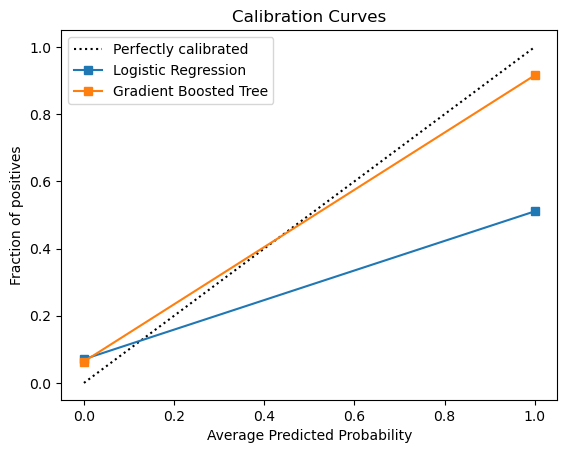

In [46]:
# Calibration curve

predictions_optimal_lr = (best_lr_model_under.predict_proba(X_test)[:, 1] > intersection_thresholds[0]).astype(int)

frac_of_pos_lr, mean_pred_val_lr = calibration_curve(y_test, predictions_optimal_lr)

predictions_optimal_xgb = (best_xgb_model.predict_proba(X_test)[:, 1] > 0.4).astype(int)

frac_of_pos_xgb, mean_pred_val_xgb = calibration_curve(y_test, predictions_optimal_xgb)

plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_lr, frac_of_pos_lr,
         's-', label='%s' % 'Logistic Regression')
plt.plot(mean_pred_val_xgb, frac_of_pos_xgb,
         's-', label='%s' % 'Gradient Boosted Tree')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curves')
plt.show()

    Acceptance Rate  Threshold  Bad Rate  Num Accepted Loans  Avg Loan Amnt  \
0              1.00      0.999     0.062                5862        7934.79   
1              0.95      0.922     0.063                5570        7927.88   
2              0.90      0.850     0.063                5275        7977.31   
3              0.85      0.772     0.062                4982        7973.89   
4              0.80      0.680     0.063                4692        8045.25   
5              0.75      0.587     0.064                4396        8007.04   
6              0.70      0.514     0.065                4105        8024.22   
7              0.65      0.453     0.064                3812        8000.33   
8              0.60      0.401     0.065                3513        8043.82   
9              0.55      0.357     0.064                3219        7971.49   
10             0.50      0.318     0.063                2936        7896.46   
11             0.45      0.281     0.062            

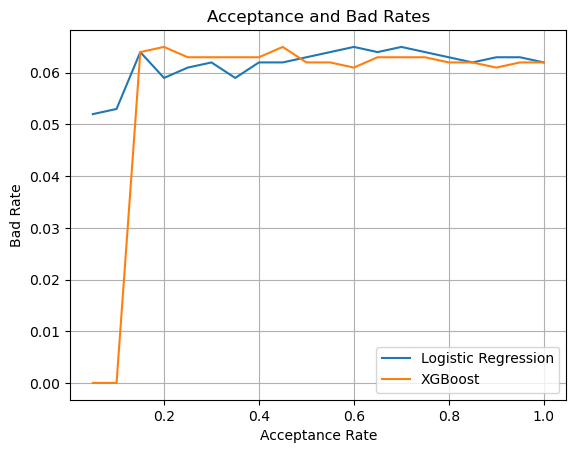

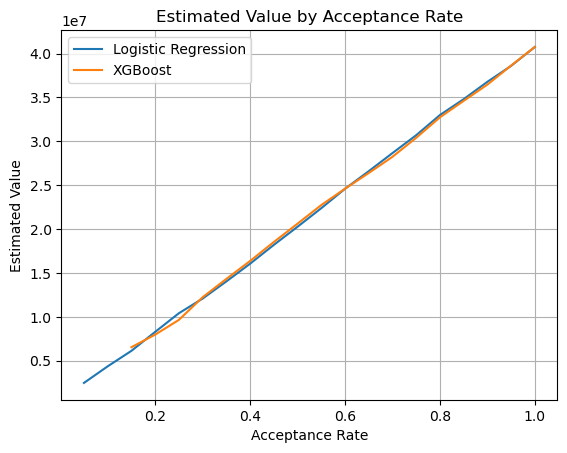

In [47]:
# Strategy table and curve for both models

accept_rates = [round(0.05 * i, 2) for i in range(20, 0, -1)]

thresholds = []
bad_rates = []
num_accepted_loans = []
avg_loan_amnt = []

for model in best_models:
    for rate in accept_rates:
        predictions_proba_test_df = pd.DataFrame(model.predict_proba(X_test)[:, 1], columns=['prob_default'])
        predictions_proba_test_df['true_loan_status'] = y_test
        thresh = np.quantile(predictions_proba_test_df['prob_default'], rate).round(3)
        thresholds.append(thresh)
        predictions_proba_test_df['pred_loan_status'] = predictions_proba_test_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
        accepted_loans_indices = predictions_proba_test_df[predictions_proba_test_df['pred_loan_status'] == 0].index
        mean_accepted_loan_amount = X_test.loc[X_test.index.isin(accepted_loans_indices), 'loan_amnt'].mean()
        avg_loan_amnt.append(mean_accepted_loan_amount)
        accepted_loans = predictions_proba_test_df[predictions_proba_test_df['pred_loan_status'] == 0]
        num_accepted_loans.append(len(accepted_loans['true_loan_status']))
        bad_rates.append(np.sum((accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])).round(3))


thresholds_lr = thresholds[:20]
bad_rates_lr = bad_rates[:20]
num_accepted_loans_lr = num_accepted_loans[:20]
avg_loan_amnt_lr = avg_loan_amnt[:20]

thresholds_xgb = thresholds[-20:]
bad_rates_xgb = bad_rates[-20:]
num_accepted_loans_xgb = num_accepted_loans[-20:]
avg_loan_amnt_xgb = avg_loan_amnt[-20:]

strat_lr = pd.DataFrame(zip(accept_rates, thresholds_lr, bad_rates_lr, num_accepted_loans_lr, avg_loan_amnt_lr),
                        columns = ['Acceptance Rate','Threshold','Bad Rate', 'Num Accepted Loans', 'Avg Loan Amnt'])

strat_lr['Estimated Value'] = ((strat_lr['Num Accepted Loans'] * (1 - strat_lr['Bad Rate'])) * strat_lr['Avg Loan Amnt']) - (strat_lr['Num Accepted Loans'] * strat_lr['Bad Rate'] * strat_lr['Avg Loan Amnt'])

strat_lr['Avg Loan Amnt'] = strat_lr['Avg Loan Amnt'].map('{:.2f}'.format).astype(float)
strat_lr['Estimated Value'] = strat_lr['Estimated Value'].map('{:.2f}'.format).astype(float)

strat_xgb = pd.DataFrame(zip(accept_rates, thresholds_xgb, bad_rates_xgb, num_accepted_loans_xgb, avg_loan_amnt_xgb),
                        columns = ['Acceptance Rate','Threshold','Bad Rate', 'Num Accepted Loans', 'Avg Loan Amnt'])

strat_xgb['Estimated Value'] = ((strat_xgb['Num Accepted Loans'] * (1 - strat_xgb['Bad Rate'])) * strat_xgb['Avg Loan Amnt']) - (strat_xgb['Num Accepted Loans'] * strat_xgb['Bad Rate'] * strat_xgb['Avg Loan Amnt'])

strat_xgb['Avg Loan Amnt'] = strat_xgb['Avg Loan Amnt'].map('{:.2f}'.format).astype(float)
strat_xgb['Estimated Value'] = strat_xgb['Estimated Value'].map('{:.2f}'.format).astype(float)

print(strat_lr)
print('-----------------------------------------------------------------')
print(strat_xgb)

#Strategy curves

plt.plot(strat_lr['Acceptance Rate'], strat_lr['Bad Rate'], label='Logistic Regression')
plt.plot(strat_xgb['Acceptance Rate'], strat_xgb['Bad Rate'], label='XGBoost')
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(strat_lr['Acceptance Rate'],strat_lr['Estimated Value'], label='Logistic Regression')
plt.plot(strat_xgb['Acceptance Rate'],strat_xgb['Estimated Value'], label='XGBoost')
plt.title('Estimated Value by Acceptance Rate')
plt.xlabel('Acceptance Rate')
plt.ylabel('Estimated Value')
plt.grid(True)
plt.legend()
plt.show()

In [48]:
# Total expected loss

total_expected_losses = []

for model in best_models:
    test_df = pd.DataFrame(model.predict_proba(X_test)[:, 1], columns=['PD'])
    test_df['LGD'] = 1.0
    test_df['EAD'] = X_test['loan_amnt'].reset_index(drop=True)
    total_expected_loss = (test_df['PD'] * test_df['LGD'] * test_df['EAD']).sum()
    total_expected_losses.append(total_expected_loss)

print('Total expected loss for logistic regression model: ', '${:,.2f}'.format(total_expected_losses[0]))
print('Total expected loss for XGBoost model: ', '${:,.2f}'.format(total_expected_losses[1]))

Total expected loss for logistic regression model:  $23,419,671.68
Total expected loss for XGBoost model:  $13,315,009.94
